In [4]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional

@dataclass
class ExperimentConfig:
    name: str
    classification_run: str
    seq2seq_run: str
    n_steps: int = 500

class DataProcessor:
    def __init__(self, api: wandb.Api):
        self.api = api
        self.keys = ["validation_in_domain/accuracy", "validation_in_domain/loss", 
                    "training/accuracy", "training/loss"]
    
    def get_run_data(self, run_path: str) -> pd.DataFrame:
        """Fetch and process run data from W&B."""
        run = self.api.run(run_path)
        steps = pd.DataFrame([step for step in run.scan_history(['Optimization Steps'] + self.keys)])
        return pd.DataFrame({
            'training/accuracy': steps['training/accuracy'].values,
            'validation_in_domain/accuracy': steps['validation_in_domain/accuracy'].values
        }, index=steps['Optimization Steps'])
    
    @staticmethod
    def apply_ema(df: pd.DataFrame, alpha: float = 0.1) -> pd.DataFrame:
        """Apply Exponential Moving Average smoothing."""
        smoothed = df.copy()
        for col in ['training/accuracy', 'validation_in_domain/accuracy']:
            smoothed[col] = df[col].ewm(alpha=alpha, adjust=False).mean()
        return smoothed

class Plotter:
    @staticmethod
    def create_side_by_side_plots(classification_df: pd.DataFrame, seq2seq_df: pd.DataFrame) -> Tuple[plt.Figure, List[plt.Axes]]:
        plt.style.use('default')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=150)
        
        # Classification plot
        ax1.plot(classification_df.index, classification_df['training/accuracy'],
                color='#b00000', linewidth=2, label='Training')
        ax1.plot(classification_df.index, classification_df['validation_in_domain/accuracy'],
                color='#fc0303', linewidth=2, label='Validation')
        ax1.set_title('Classification Model', fontsize=14, fontweight='bold', pad=20)
        
        # Seq2Seq plot
        ax2.plot(seq2seq_df.index, seq2seq_df['training/accuracy'],
                color='#013491', linewidth=2, label='Training')
        ax2.plot(seq2seq_df.index, seq2seq_df['validation_in_domain/accuracy'],
                color='#0259fa', linewidth=2, label='Validation')
        ax2.set_title('Seq2Seq Model', fontsize=14, fontweight='bold', pad=20)
        
        # Style both plots
        for ax in [ax1, ax2]:
            ax.set_facecolor('#f8f9fa')
            ax.grid(True, which='major', linestyle='--', alpha=0.7, color='#cccccc')
            ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
            ax.set_xlabel('Optimization Steps', fontsize=12, fontweight='bold')
            ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
            ax.set_ylim(-0.05, 1.05)
            ax.legend(loc='upper right', frameon=True, fancybox=True, 
                    shadow=True, fontsize=10)
        
        fig.patch.set_facecolor('#ffffff')
        plt.tight_layout()
        return fig, [ax1, ax2]
    
    @staticmethod
    def create_plot(classification_df: pd.DataFrame, seq2seq_df: pd.DataFrame) -> Tuple[plt.Figure, plt.Axes]:
        plt.style.use('default')
        fig, ax = plt.subplots(figsize=(12, 7), dpi=150)
        
        # Plot data
        ax.plot(classification_df.index, classification_df['training/accuracy'],
                color='#b00000', linewidth=2, label='Classification - Training')
        ax.plot(classification_df.index, classification_df['validation_in_domain/accuracy'],
                color='#fc0303', linewidth=2, label='Classification - Validation')
        ax.plot(seq2seq_df.index, seq2seq_df['training/accuracy'],
                color='#013491', linewidth=2, label='Seq2Seq - Training')
        ax.plot(seq2seq_df.index, seq2seq_df['validation_in_domain/accuracy'],
                color='#0259fa', linewidth=2, label='Seq2Seq - Validation')
        
        # Style plot
        ax.set_facecolor('#f8f9fa')
        fig.patch.set_facecolor('#ffffff')
        ax.grid(True, which='major', linestyle='--', alpha=0.7, color='#cccccc')
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
        
        # Labels and title
        ax.set_xlabel('Optimization Steps', fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Training and Validation Accuracy Comparison\nClassification vs Seq2Seq Models',
                    fontsize=14, fontweight='bold', pad=20)
        
        # Legend and formatting
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
                 borderaxespad=0, frameon=True, fancybox=True,
                 shadow=True, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        ax.set_ylim(-0.05, 1.05)
        
        plt.tight_layout()
        return fig, ax

class ExperimentRunner:
    def __init__(self, api: wandb.Api):
        self.processor = DataProcessor(api)
        self.plotter = Plotter()
    
    def run_experiment(self, config: ExperimentConfig) -> None:
        """Run complete experiment workflow."""
        # Fetch data
        classification_df = self.processor.get_run_data(config.classification_run)
        seq2seq_df = self.processor.get_run_data(config.seq2seq_run)
        
        # Apply EMA smoothing
        classification_df_smooth = self.processor.apply_ema(classification_df)
        seq2seq_df_smooth = self.processor.apply_ema(seq2seq_df)
        
        # Create and display plot
        self.plotter.create_side_by_side_plots(
            classification_df_smooth[:config.n_steps],
            seq2seq_df_smooth[:config.n_steps]
        )
        plt.show()




Running experiment: Standard Addition


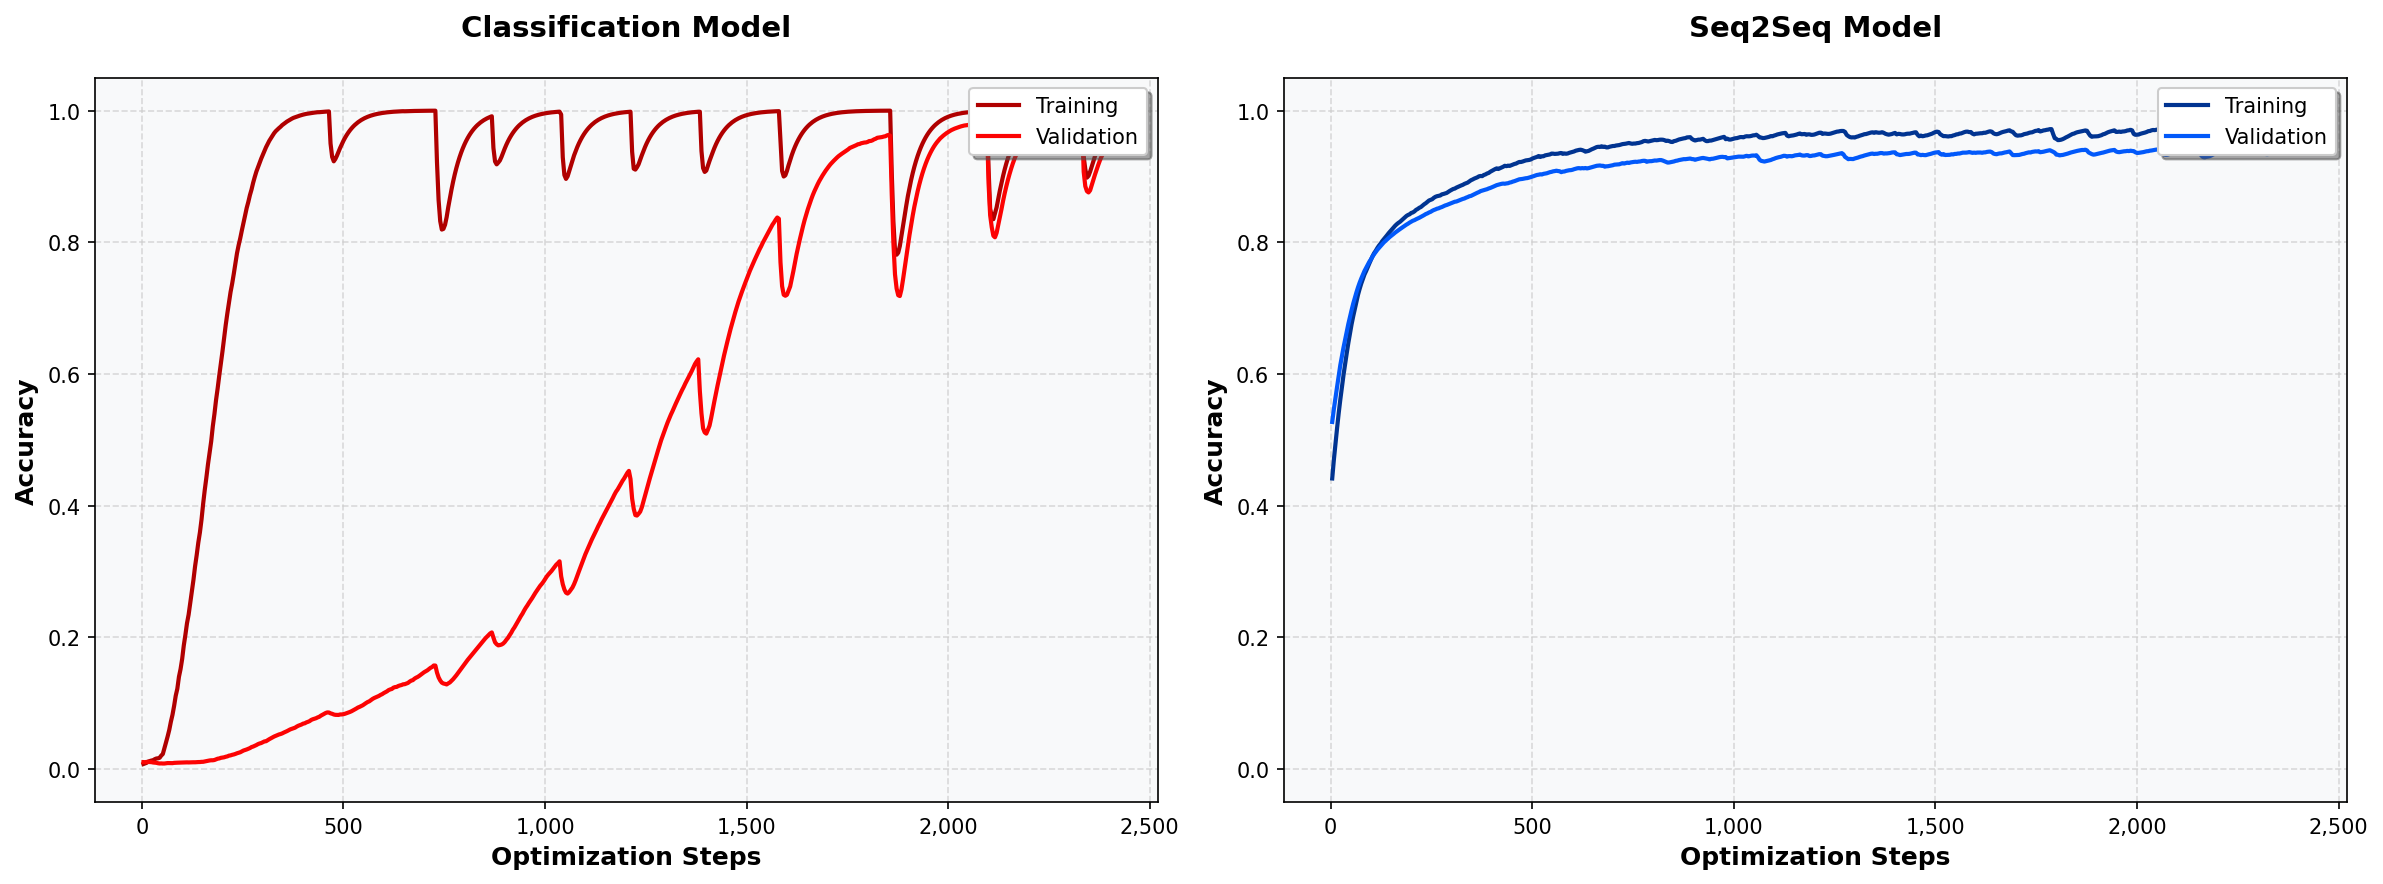


Running experiment: Mod Division


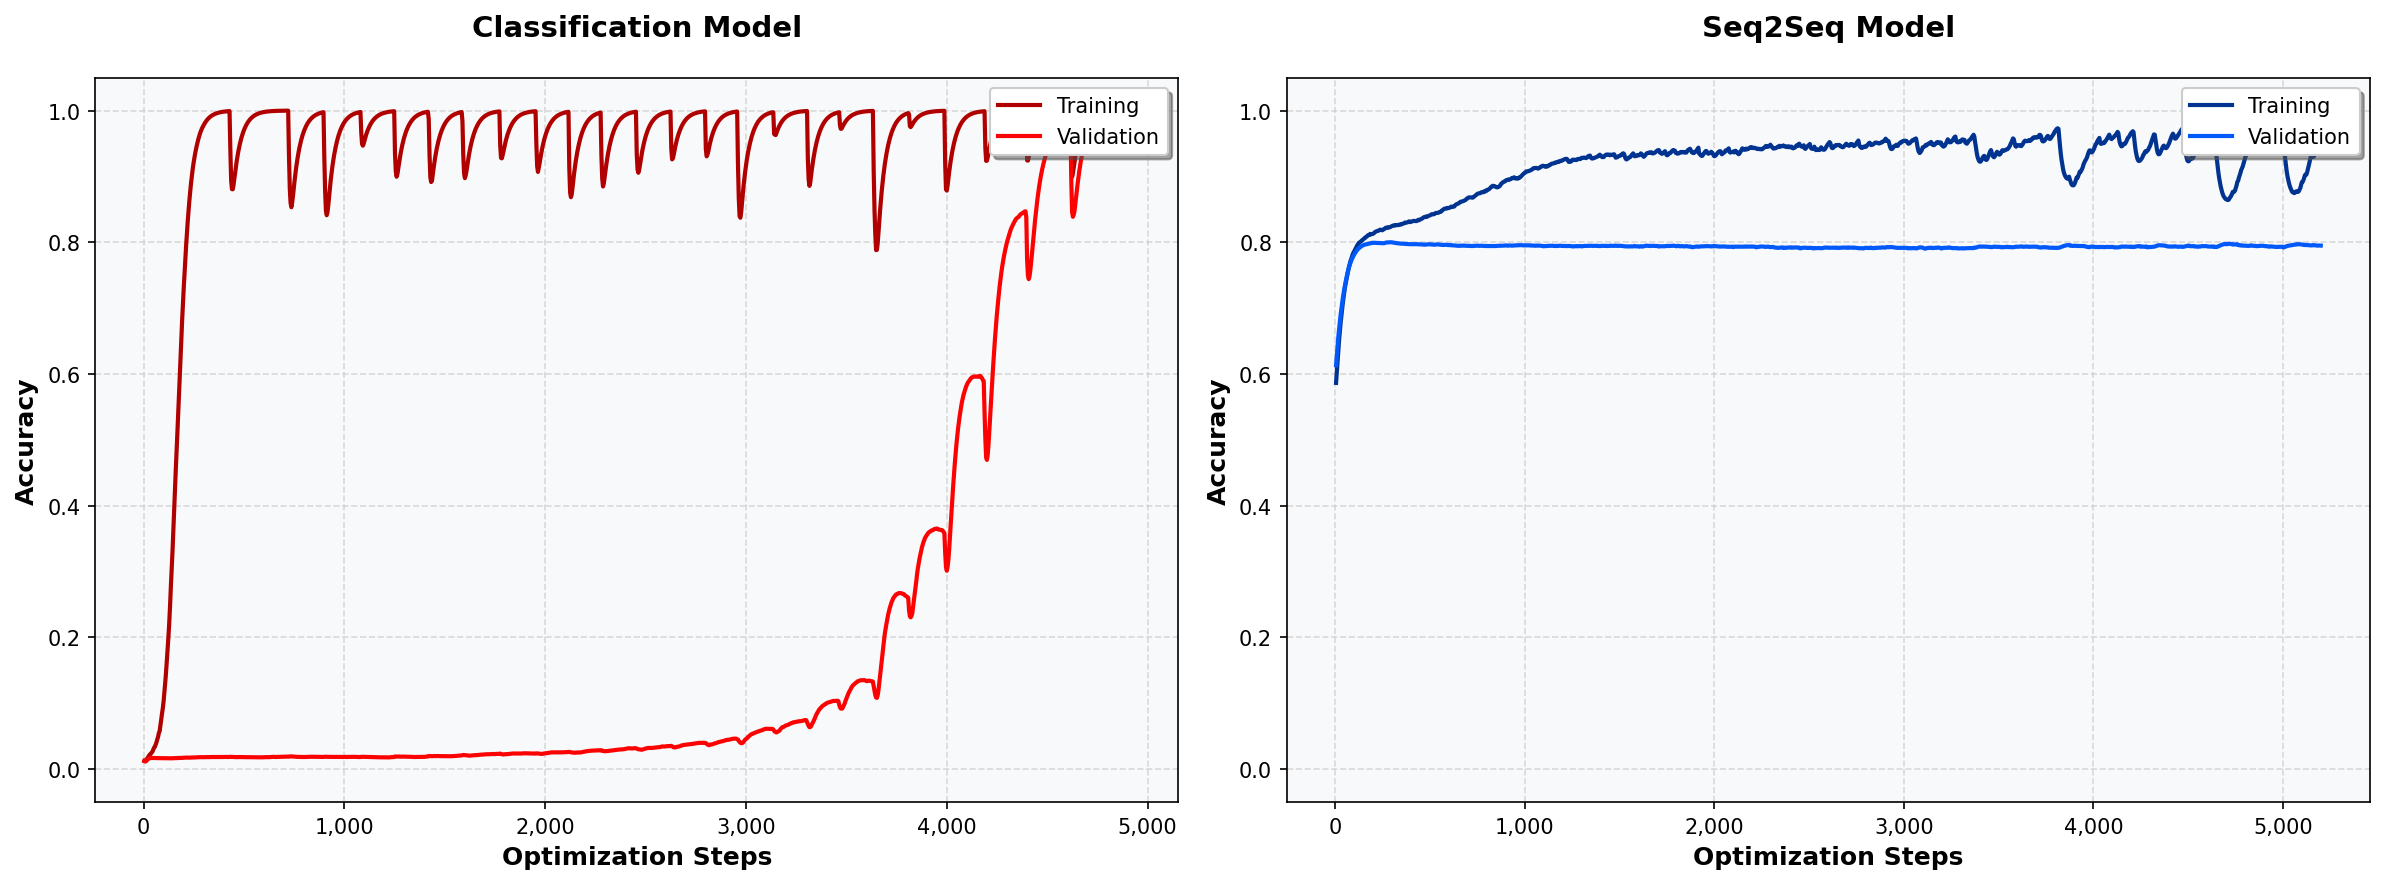

In [5]:
# Initialize W&B API
api = wandb.Api()

# Define experiments
experiments = [
    ExperimentConfig(
        name="Standard Addition",
        classification_run="philliplakaschus/grokking/fsiagb6p",
        seq2seq_run="philliplakaschus/grokking/037zy55b",
        n_steps=600
    ),
    ExperimentConfig(
        name="Mod Division",
        classification_run="philliplakaschus/grokking/pc91aug1",
        seq2seq_run="philliplakaschus/grokking/qdp01q6k",
        n_steps=1300
    )
]

# Run experiments
runner = ExperimentRunner(api)
for experiment in experiments:
    print(f"\nRunning experiment: {experiment.name}")
    runner.run_experiment(experiment)